In [17]:
import pandas as pd
import pyTigerGraph as tg
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Data Processing

### Get accounts

In [2]:
accounts = pd.read_csv("data/accounts.csv", usecols=["ACCOUNT_ID","IS_FRAUD"])

In [3]:
accounts.head()

,ACCOUNT_ID,IS_FRAUD
0,0x1f1e784a61a8ca0a90250bcd2170696655b28a21,False
1,0x1266f8b9e4dffc9e2f719bf51713f7e714516861,False
2,0xbbfaf27674c2eb5d13edc58a40081248d13dcfeb,True
3,0x256fc19e9d8f5be0d451841f218289d1adbbaaa3,False
4,0xb50d0c4cb2c29cc232c96a59e9c65eb82914ec75,False


### Get embeddings

#### FastRP embedding

In [56]:
fastRP_embed = pd.read_csv("output/fastRP_embedding.txt", 
                           sep=',',
                           header=None,
                           names=["account","embed"])

fastRP_embed.head()

,account,embed
0,0x7b4349dc5d5ea8928f1827ce84c069bb62d12c52,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
1,0xea2dc38d1a95bd35dc894d8bc32cd79d661eea36,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
2,0x7af80f69cb27e788941dff4e90ccc49ac397853f,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...
3,0x3cf8f58e380edfa5d1ff6886ce3d8a02b1f0d552,2194.57 1479.52 -1762.89 7360.86 -2431.03 -835...
4,0xcc372f13ffb47c7ff4eea06147faf129a8fa5637,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


In [57]:
# The embed column is a string of numbers separated by space.
# Split it into multiple columns of type float
x = fastRP_embed.embed.str.split(' ', expand=True)
x.drop(columns=[64], inplace=True)
fastRP_embed = pd.concat([fastRP_embed.drop(columns="embed"),
                          x.astype("float")],
                         axis=1)
del x
fastRP_embed.dropna(inplace=True)
fastRP_embed.head()

,account,0,1,2,3,4,5,6,7,8,...,54,55,56,57,58,59,60,61,62,63
0,0x7b4349dc5d5ea8928f1827ce84c069bb62d12c52,0.00,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.00,...,0.000,0.00,0.0,0.0000,0.000,0.00,0.00,0.00,0.00,0.000
1,0xea2dc38d1a95bd35dc894d8bc32cd79d661eea36,0.00,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.00,...,0.000,0.00,0.0,0.0000,0.000,0.00,0.00,0.00,0.00,0.000
2,0x7af80f69cb27e788941dff4e90ccc49ac397853f,0.00,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.00,...,0.000,0.00,0.0,0.0000,0.000,0.00,0.00,0.00,0.00,0.000
3,0x3cf8f58e380edfa5d1ff6886ce3d8a02b1f0d552,2194.57,1479.52,-1762.89,7360.86,-2431.03,-835.994,-2066.69,2287.82,-1014.63,...,373.702,5405.98,4531.8,-54.5398,298.242,-2641.78,1434.34,7780.52,3906.24,835.882
4,0xcc372f13ffb47c7ff4eea06147faf129a8fa5637,0.00,0.00,0.00,0.00,0.00,0.000,0.00,0.00,0.00,...,0.000,0.00,0.0,0.0000,0.000,0.00,0.00,0.00,0.00,0.000


#### Node2vec embeddings

In [6]:
node2vec_embed = pd.read_csv("output/node2vec_embedding.txt", 
                             sep=' ', 
                             header=None, 
                             skiprows=1)

node2vec_embed.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0x65e2c5175e2e618f48e70343b14c31b280e42d90,0.967964,-0.421936,0.457550,1.518400,-0.068242,-0.690476,0.513820,-1.142300,0.924335,...,-0.158941,1.794950,-2.099200,0.378948,1.603630,0.106889,1.319240,0.335497,0.225413,-1.275500
1,0x9cfed76501ac8cf181a9d9fead5af25e2c901959,-0.151631,0.352314,-0.007616,-0.176231,-0.378627,-0.342744,0.391523,-0.211865,0.716971,...,0.551856,1.022940,1.718400,-0.685194,-0.595346,-1.110900,-0.849045,0.849518,-0.345994,0.120550
2,0xf34839b310097fcb4cf3a302dda8cc9b57501083,1.329600,-1.207440,0.374457,-0.742986,1.519620,0.106588,-0.285240,0.004167,-0.234160,...,-0.069016,0.220734,0.592446,0.421798,0.004992,-0.730427,0.105916,0.298354,-0.627880,0.796520
3,0x876eabf441b2ee5b5b0554fd502a8e0600950cfa,0.853252,0.322837,-0.453203,0.176094,-0.536670,0.575405,0.664975,-0.554903,0.487460,...,0.595281,0.335211,0.864520,0.469365,0.543479,-0.754712,-0.585018,-0.143784,0.317106,0.626127
4,0xbc6882b87f746e129cb4a153c23ae236a5e3f835,0.992525,-0.719603,0.553679,0.129265,1.039170,0.274587,-0.771650,-0.144886,0.036865,...,-0.234721,0.109403,1.015550,0.723129,0.014384,-0.095458,0.226477,0.530823,0.116831,0.850686


In [7]:
node2vec_embed.rename(columns={0:"account"}, inplace=True)
node2vec_embed.head()

,account,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0x65e2c5175e2e618f48e70343b14c31b280e42d90,0.967964,-0.421936,0.457550,1.518400,-0.068242,-0.690476,0.513820,-1.142300,0.924335,...,-0.158941,1.794950,-2.099200,0.378948,1.603630,0.106889,1.319240,0.335497,0.225413,-1.275500
1,0x9cfed76501ac8cf181a9d9fead5af25e2c901959,-0.151631,0.352314,-0.007616,-0.176231,-0.378627,-0.342744,0.391523,-0.211865,0.716971,...,0.551856,1.022940,1.718400,-0.685194,-0.595346,-1.110900,-0.849045,0.849518,-0.345994,0.120550
2,0xf34839b310097fcb4cf3a302dda8cc9b57501083,1.329600,-1.207440,0.374457,-0.742986,1.519620,0.106588,-0.285240,0.004167,-0.234160,...,-0.069016,0.220734,0.592446,0.421798,0.004992,-0.730427,0.105916,0.298354,-0.627880,0.796520
3,0x876eabf441b2ee5b5b0554fd502a8e0600950cfa,0.853252,0.322837,-0.453203,0.176094,-0.536670,0.575405,0.664975,-0.554903,0.487460,...,0.595281,0.335211,0.864520,0.469365,0.543479,-0.754712,-0.585018,-0.143784,0.317106,0.626127
4,0xbc6882b87f746e129cb4a153c23ae236a5e3f835,0.992525,-0.719603,0.553679,0.129265,1.039170,0.274587,-0.771650,-0.144886,0.036865,...,-0.234721,0.109403,1.015550,0.723129,0.014384,-0.095458,0.226477,0.530823,0.116831,0.850686


### Train-test split

In [8]:
fraud_accounts = accounts.loc[accounts.IS_FRAUD==True, "ACCOUNT_ID"]
normal_accounts = accounts.loc[accounts.IS_FRAUD==False, "ACCOUNT_ID"]
fraud_train, fraud_test = train_test_split(fraud_accounts, test_size=0.1)
normal_train, normal_test = train_test_split(normal_accounts, test_size=0.1)

## Model Training

In [9]:
# Helper function to load batches of data
def build_dataloader(df, batch_size, shuffle=True):
    if shuffle:
        df = df.sample(frac=1).reset_index(drop=True)
    i=0
    for i in range(batch_size, len(df), batch_size):
        yield df[i-batch_size : i]
    yield df[i:]

# Function to test the accuracy and recall of the model
def test(model, fraud_test, normal_test):
    positive = fraud_test.iloc[:,1:].to_numpy()
    negative = normal_test.iloc[:,1:].to_numpy()
    input_embeds = torch.from_numpy(np.concatenate([positive,negative])).float()
    labels = torch.cat([torch.ones(positive.shape[0], dtype=torch.long),
                        torch.zeros(negative.shape[0], dtype=torch.long)])
    with torch.no_grad():
        output = model(input_embeds)
        prediction = output.argmax(axis=1)
        accuracy = (labels==prediction).sum()/len(labels)
        recall = (labels*prediction).sum()/labels.sum()
        print("Accuracy:{:.5}, Recall:{:.5}".format(
              accuracy.item(), recall.item()))

### FastRP Embedding

In [58]:
# Get embeddings for training set
fraud_embed_train = fastRP_embed.merge(fraud_train, left_on="account", right_on="ACCOUNT_ID")
fraud_embed_train.drop(columns="ACCOUNT_ID", inplace=True)
normal_embed_train = fastRP_embed.merge(normal_train, left_on="account", right_on="ACCOUNT_ID")
normal_embed_train.drop(columns="ACCOUNT_ID", inplace=True)

# Get embeddings for test set
fraud_embed_test = fastRP_embed.merge(fraud_test, left_on="account", right_on="ACCOUNT_ID")
fraud_embed_test.drop(columns="ACCOUNT_ID", inplace=True)
normal_embed_test = fastRP_embed.merge(normal_test, left_on="account", right_on="ACCOUNT_ID")
normal_embed_test.drop(columns="ACCOUNT_ID", inplace=True)

#### Build model

In [80]:
# Hyperparameters
embed_size = 64
hidden_size = 64
batch_size = 64
lr = 0.0001
epochs=20

# A 3 layer fully connected neural network
fastRP_model = nn.Sequential(nn.Linear(embed_size, hidden_size), 
                      nn.ReLU(),
                      nn.Linear(hidden_size, 2))

loss = nn.CrossEntropyLoss(reduction="sum")

updater = torch.optim.SGD(fastRP_model.parameters(), lr=lr)

#### Train model

In [81]:
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch in build_dataloader(fraud_embed_train, batch_size):
        positive = batch.iloc[:,1:].to_numpy()
        negative = normal_embed_train.sample(batch.shape[0]).iloc[:,1:].to_numpy()
        labels = torch.cat([torch.ones(positive.shape[0], dtype=torch.long),
                            torch.zeros(negative.shape[0], dtype=torch.long)])
        input_embeds = torch.from_numpy(np.concatenate([positive,negative])).float()
        output = fastRP_model(input_embeds)
        ls = loss(output, labels)
        with torch.no_grad():
            updater.zero_grad()
            ls.backward()
            torch.nn.utils.clip_grad_norm_(fastRP_model.parameters(), 0.001)
            updater.step()
            epoch_loss += ls.item()
    print("Epoch:{}, Loss:{:.5},".format(epoch, epoch_loss/fraud_embed_train.shape[0]), end=' ')
    test(fastRP_model, fraud_embed_test, normal_embed_test)

Epoch:0, Loss:3.3621e+04, Accuracy:0.20304, Recall:0.71304
Epoch:1, Loss:3.2609e+04, Accuracy:0.20304, Recall:0.71304
Epoch:2, Loss:3.1219e+04, Accuracy:0.20304, Recall:0.71304
Epoch:3, Loss:3.4902e+04, Accuracy:0.20304, Recall:0.71304
Epoch:4, Loss:2.8646e+04, Accuracy:0.20304, Recall:0.71304
Epoch:5, Loss:3.6366e+04, Accuracy:0.20304, Recall:0.71304
Epoch:6, Loss:3.1212e+04, Accuracy:0.20304, Recall:0.71304
Epoch:7, Loss:3.106e+04, Accuracy:0.20304, Recall:0.71304
Epoch:8, Loss:3.352e+04, Accuracy:0.20304, Recall:0.71304
Epoch:9, Loss:3.468e+04, Accuracy:0.20304, Recall:0.71304
Epoch:10, Loss:3.1936e+04, Accuracy:0.20304, Recall:0.71304
Epoch:11, Loss:3.0839e+04, Accuracy:0.20304, Recall:0.71304
Epoch:12, Loss:2.8471e+04, Accuracy:0.20304, Recall:0.71304
Epoch:13, Loss:3.3789e+04, Accuracy:0.20304, Recall:0.71304
Epoch:14, Loss:3.27e+04, Accuracy:0.20304, Recall:0.71304
Epoch:15, Loss:3.1759e+04, Accuracy:0.20304, Recall:0.71304
Epoch:16, Loss:3.0468e+04, Accuracy:0.20304, Recall:0.7

### Node2vec Embedding

#### Build model

In [14]:
# Hyperparameters
embed_size = 64
hidden_size = 64
batch_size = 64
lr = 0.001
epochs=50

# A 3 layer fully connected neural network
node2vec_model = nn.Sequential(nn.Linear(embed_size, hidden_size), 
                      nn.ReLU(),
                      nn.Linear(hidden_size, 2))

loss = nn.CrossEntropyLoss(reduction="sum")

updater = torch.optim.SGD(node2vec_model.parameters(), lr=lr)

#### Train model

In [15]:
# Get embeddings for training set
fraud_embed_train = node2vec_embed.merge(fraud_train, left_on="account", right_on="ACCOUNT_ID")
fraud_embed_train.drop(columns="ACCOUNT_ID", inplace=True)
normal_embed_train = node2vec_embed.merge(normal_train, left_on="account", right_on="ACCOUNT_ID")
normal_embed_train.drop(columns="ACCOUNT_ID", inplace=True)

# Get embeddings for test set
fraud_embed_test = node2vec_embed.merge(fraud_test, left_on="account", right_on="ACCOUNT_ID")
fraud_embed_test.drop(columns="ACCOUNT_ID", inplace=True)
normal_embed_test = node2vec_embed.merge(normal_test, left_on="account", right_on="ACCOUNT_ID")
normal_embed_test.drop(columns="ACCOUNT_ID", inplace=True)

In [16]:
for epoch in range(epochs):
    epoch_loss = 0.0
    for batch in build_dataloader(fraud_embed_train, batch_size):
        positive = batch.iloc[:,1:].to_numpy()
        negative = normal_embed_train.sample(batch.shape[0]).iloc[:,1:].to_numpy()
        labels = torch.cat([torch.ones(positive.shape[0], dtype=torch.long),
                            torch.zeros(negative.shape[0], dtype=torch.long)])
        input_embeds = torch.from_numpy(np.concatenate([positive,negative])).float()
        output = node2vec_model(input_embeds)
        ls = loss(output, labels)
        with torch.no_grad():
            updater.zero_grad()
            ls.backward()
            updater.step()
            epoch_loss += ls.item()
    print("Epoch:{}, Loss:{:.5},".format(epoch, epoch_loss/fraud_embed_train.shape[0]), end=' ')
    test(node2vec_model, fraud_embed_test, normal_embed_test)

Epoch:0, Loss:1.3547, Accuracy:0.20053, Recall:1.0
Epoch:1, Loss:1.2583, Accuracy:0.73193, Recall:0.93578
Epoch:2, Loss:1.1211, Accuracy:0.82912, Recall:0.93578
Epoch:3, Loss:0.99305, Accuracy:0.87989, Recall:0.93578
Epoch:4, Loss:0.84475, Accuracy:0.89154, Recall:0.91743
Epoch:5, Loss:0.73408, Accuracy:0.89779, Recall:0.89908
Epoch:6, Loss:0.67017, Accuracy:0.90726, Recall:0.88073
Epoch:7, Loss:0.60623, Accuracy:0.90771, Recall:0.88073
Epoch:8, Loss:0.59493, Accuracy:0.90918, Recall:0.88073
Epoch:9, Loss:0.56111, Accuracy:0.91296, Recall:0.88073
Epoch:10, Loss:0.53779, Accuracy:0.90986, Recall:0.88991
Epoch:11, Loss:0.57133, Accuracy:0.91562, Recall:0.88073
Epoch:12, Loss:0.5645, Accuracy:0.91836, Recall:0.88073
Epoch:13, Loss:0.53862, Accuracy:0.91623, Recall:0.88073
Epoch:14, Loss:0.54381, Accuracy:0.91509, Recall:0.88073
Epoch:15, Loss:0.50647, Accuracy:0.91435, Recall:0.88991
Epoch:16, Loss:0.47439, Accuracy:0.91188, Recall:0.88991
Epoch:17, Loss:0.50772, Accuracy:0.9175, Recall:0

### Visualize Result

In [82]:
performance_df = pd.DataFrame({
    "Method": np.repeat(["Node2vec", "fastRP", "Always Fraud", "Never Fraud", "Random"],2) ,
    "Metric": ["Accuracy", "Recall"]*5,
    "Score": [0.91138, 0.89908, 
              0.20304, 0.71304, 
              fraud_embed_test.shape[0]/(fraud_embed_test.shape[0]+normal_embed_test.shape[0]), 1,
              normal_embed_test.shape[0]/(fraud_embed_test.shape[0]+normal_embed_test.shape[0]), 0,
              0.5,0.5]
})

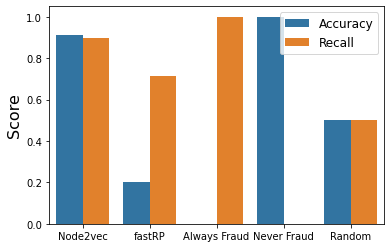

In [90]:
sns.barplot(data=performance_df, x="Method", y="Score", hue="Metric");
plt.xlabel("");
plt.ylabel("Score", fontsize=16);
plt.legend(fontsize=12);